### BUFN400---University of Maryland 

# Homework 2: Bonds and Mortgages: Theoretical Calculations

### By Albert S. (Pete) Kyle

There are probably some typos or errors in this homework.  If you find something which seems wrong, please let me know!

$\require{\newcommand}$
$\require{\renewcommand}$
$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\e}{\mathrm{e}}$
$\newcommand{\drm}{\mathrm{\, d}}$
$\newcommand{\var}{\mathrm{var}}$
$\newcommand{\cov}{\mathrm{cov}}$
$\newcommand{\stdev}{\mathrm{stdev}}$
$\newcommand{\sm}{ {\scriptstyle{*}} }$
$\renewcommand{\mm}{{\scriptsize @}}$
$\renewcommand{\t}{^{\mathsf{T}}}$
$\renewcommand{\comma}{\, , \,}$
$\renewcommand{\vec}[1]{\mathbf{#1}}$


In [1]:
import pandas as pd
import numpy as np
import scipy
#import scipy.sparse.linalg

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import io
import datetime
import timeit

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 100)
#pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NumPy version ' + np.__version__)
print('SciPy version ' + scipy.__version__)
print('matplotlib version ' + matplotlib.__version__)

timestamp = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
print("Timestamp:", timestamp)
tstart = timeit.default_timer()


Python version 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:47:18) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.0.3
NumPy version 1.25.2
SciPy version 1.11.1
matplotlib version 3.7.1
Timestamp: 2023-0926-1713


### Exercise 1

The purpose of this exercise is to make sure you understand how cash flows on different types of bonds differ from one another. In fixed income markets, different types of bonds are issued by different types of issuers.

* The U.S. government tends to issue coupon bonds which pay semi-annual interest and pay back the entire face value at maturity. This type of bond has **no amortization of principal**.

* Individual homeowners often borrow with 30-year, fixed rate mortgages whose monthly payments are constant (like annuities) and pay back the amount of the loan gradually, so that the entire loan is fully repaid with the last (360th) monthly payment.  This type of bond has **full amortization of principal** over the life of the loan. If paid back before maturity, the is a principal balance outstanding which must be prepaid.  At maturity, the principal balance is zero after the final (360th) payment.

* Commercial real estate borrowers often borrow with maturities shorter than 30 years (say 10 years). Monthly payments correspond to those on a longer maturity mortgage (say 30 years). At the maturity date, there is a principal balance outstanding which must be paid (**balloon payment**) because the amortization schedule (based on say a 30-year mortgage) does not pay back the entire principal amount at maturity.  This type of bond has **partial amortization of principal** over the life of the loan.

1. Write function which takes inputs and produces outputs described by the doc-string in the next cell. This function should cover all three types of amortization schedules mentioned above.

2. Display the first 5 lines and last 5 lines of dataframes returned for three cases, each of which has face value of 100,000 and coupon of 6 percent of face value. The three cases are:

* U.S Treasury security: maturity of 10 years, no amortization of principal.

* Residential mortgage: maturity = 30 years, amortization_horizon = 30 years.

* Commercial real estate: maturity = 10 years, amortization_horizon = 30 years. (Hint for debugging: My calculations indicate amount owed after last payment is about 83685 dollars. If you think my answer is incorrect, please let me know. Your answer should show both dollars and cents.)

2. In one sentence, explain why this function depends on the coupon rate but does not depend on the yield to maturity.

Hints: 

A. It is hard to write this function without using a Python loop, so a Python loop is okay in this case.

B. When principal is amortized, you probably want to use an annuity formula (see lecture notes) to determine the monthly payment.

C. For nice display, you might use `pd.set_option('display.float_format', lambda x: '%.2f' % x)` to display results to cents. This option is already set in the cell above which loads packages.


In [2]:
def f_balance(loan_amount, coupon_rate, maturity, amortization_horizon=None, num_per_year=12):
    # Initialize data lists
    pre_balances = [loan_amount]
    post_balances = [loan_amount]
    payments = [0]
    interests = [0]
    principals = [0]
    
    # If amortization_horizon is None, it's an interest only loan
    if amortization_horizon is None:
        fixed_payment = loan_amount * (coupon_rate / num_per_year)
    else:
        # Annuity formula to compute fixed monthly payment for amortizing loans
        r = coupon_rate / num_per_year
        n = num_per_year * amortization_horizon
        fixed_payment = loan_amount * (r / (1 - (1 + r) ** -n))
    
    # Loop for each period to compute payments, interests, principals, and balances
    for i in range(1, num_per_year * maturity + 1):
        interest = post_balances[-1] * (coupon_rate / num_per_year)
        principal = fixed_payment - interest if i <= num_per_year * (amortization_horizon or 0) else 0
        post_balance = post_balances[-1] - principal
        
        payments.append(fixed_payment if i <= num_per_year * (amortization_horizon or 0) else interest)
        interests.append(interest)
        principals.append(principal)
        pre_balances.append(post_balance + interests[-1])
        post_balances.append(post_balance)
        
    # Create dataframe from the lists
    df = pd.DataFrame({
        'prebalance': pre_balances,
        'payment': payments,
        'interest': interests,
        'principal': principals,
        'post_balance': post_balances
    })
    
    return df

# Set display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)
residential_mortgage = f_balance(100000, 0.06, 30, 30)
residential_mortgage.head()

,prebalance,payment,interest,principal,post_balance
0,100000.00,0.00,0.00,0.00,100000.00
1,100400.45,599.55,500.00,99.55,99900.45
2,100299.90,599.55,499.50,100.05,99800.40
3,100198.85,599.55,499.00,100.55,99699.85
4,100097.30,599.55,498.50,101.05,99598.80


In [3]:
# U.S. Treasury:
us_treasury = f_balance(100000, 0.06, 10)
us_treasury.head()

,prebalance,payment,interest,principal,post_balance
0,100000.00,0.00,0.00,0,100000
1,100500.00,500.00,500.00,0,100000
2,100500.00,500.00,500.00,0,100000
3,100500.00,500.00,500.00,0,100000
4,100500.00,500.00,500.00,0,100000


In [4]:
us_treasury.tail()

,prebalance,payment,interest,principal,post_balance
116,100500.00,500.00,500.00,0,100000
117,100500.00,500.00,500.00,0,100000
118,100500.00,500.00,500.00,0,100000
119,100500.00,500.00,500.00,0,100000
120,100500.00,500.00,500.00,0,100000


In [5]:
residential_mortgage = f_balance(100000, 0.06, 30, 30)
residential_mortgage.head()

,prebalance,payment,interest,principal,post_balance
0,100000.00,0.00,0.00,0.00,100000.00
1,100400.45,599.55,500.00,99.55,99900.45
2,100299.90,599.55,499.50,100.05,99800.40
3,100198.85,599.55,499.00,100.55,99699.85
4,100097.30,599.55,498.50,101.05,99598.80


In [6]:
residential_mortgage.tail()

,prebalance,payment,interest,principal,post_balance
356,2383.29,599.55,14.77,584.78,2368.52
357,1792.66,599.55,11.84,587.71,1780.81
358,1199.07,599.55,8.90,590.65,1190.17
359,602.52,599.55,5.95,593.60,596.57
360,2.98,599.55,2.98,596.57,-0.00


In [7]:
commercial_real_estate = f_balance(100000, 0.06, 10, 30)
commercial_real_estate.head()

,prebalance,payment,interest,principal,post_balance
0,100000.00,0.00,0.00,0.00,100000.00
1,100400.45,599.55,500.00,99.55,99900.45
2,100299.90,599.55,499.50,100.05,99800.40
3,100198.85,599.55,499.00,100.55,99699.85
4,100097.30,599.55,498.50,101.05,99598.80


In [8]:
commercial_real_estate.tail()

,prebalance,payment,interest,principal,post_balance
116,84824.14,599.55,422.89,176.66,84401.25
117,84645.71,599.55,422.01,177.54,84223.70
118,84466.39,599.55,421.12,178.43,84045.27
119,84286.17,599.55,420.23,179.32,83865.95
120,84105.05,599.55,419.33,180.22,83685.72


### Exercise 1 (continued). Extra credit problem

3. Extra credit: Try to make the function `f_balance` numerically efficient by using the Python package Numba to make loops faster. For example, use what appears to be a dumb Python loop over a Numpy array, but speed it up with the Numba decorator `@numba.njit(...)` and the use of `numba.prange` instead of Python's `range`. Since Numba may not recognize Panda's dataframes, modify the function `f_balance` so that the function `f_balance` calls another function which is compiled with Numba and returns a tuple of numpy arrays.

    * Hint: To get this to work without taking a deep dive into the Numba documentation, you should write the Numba function in a seemingly dumb, simplistic manner which makes it easy for Numba's **just-in-time** (**jit**) compiler to infer the types of arguments to the functions. Numba recognizes Numpy arrays but does not recognize some other data types.  To get you started, here is an example using Numba to calculate an inner product. When a Numba-compiled function is called for the first time, the jit compiler takes some time to compile the function.  Therefore, it is a good idea to call the function once before timing it, so tht compile time is not part of the function timing.

4. By what factor does the use of Numba decrease execution time? 

5. In two sentences, provide an intuitive explanation for the different timings of `np.dot`, `f_inner_product_fast`, and `f_inner_product_slow` in the sample code below.

    * Hint: Consider both the speed of Python loops and whether multiple processers are used.

6. In one sentence, provide an intuitive explanation for speedups you see in your Numba function.

In [ ]:
import numba

def f_inner_product_slow(x, y):
    assert x.shape == y.shape
    assert x.ndim == 1
    res = 0.00
    for n in range(len(x)):
        res = res + x[n] * y[n]
    return res

# @numba.njit(parallel=True, fastmath=True)
@numba.njit()
def f_inner_product_fast(x, y):
    assert x.shape == y.shape
    assert x.ndim == 1
    res = 0.00
    for n in numba.prange(len(x)):
        res = res + x[n] * y[n]
    return res

# Test inner product on random vectors of length N:

N = 10**6

rng = np.random.default_rng(seed=1234)
x = rng.normal(loc=1.00, scale=5.00, size=N)
y = rng.normal(loc=0.00, scale=1.00, size=N)

res00 = np.dot(x, y)
res0 = x @ y
res1 = f_inner_product_slow(x, y)
res2 = f_inner_product_fast(x, y)
    
print(f"Should be the same: {res00=}, {res0=}, {res1=}, {res2=}\n")    

# Time the three different functions to see which is fastest:

for _ in range(3):
    print("np.dot: ", end="")
    %timeit -r 5 -n 21 res = np.dot(x, y)
    print("f_inner_product_fast: ", end="")
    %timeit -r 5 -n 11 res = f_inner_product_fast(x, y)
    print("f_inner_product_slow: ", end="")
    %timeit -r 3 -n 1 res = f_inner_product_slow(x, y)
    print("")

### Exercise 2

In the lecture note on Time Value of Money, there was a specific yield-curve function with three parameters (long rate, short rate, "mean reversion" parameter).  Use this function (with the same parameters) for this exercise. The function is copied to the cell below.

Interpret this yield curve as based on continuously compounded interest rates.

1.  Assume (perhaps unwisely?) that this yield curve is unchanging in the sense that at every future date, an investor expects to see the same yield curve function. This creates the subjective possibility of **riding the yield curve** by investing in longer-dated securities rather than shorter dated ones. 

    * For various holding periods $\Delta t$ (say one month, six months, one year, two years, five years), plot the annualized rate of return for buying a security of maturity $m$, then selling it $\Delta t$ periods of time later. Find (by numerical experimentation or otherwise) the maturity $m$ at which an investment gives the highest return. (Hint: The answer can be obtained by taking a ratio of discount factors.)

    * In one or two sentences, provide some intuition for your result to explain why the best strategy may actually avoid the longest maturity. (This may be contrary to the intuition in the class notes, which I may need to revise.)

3. Now assume that the yield curve is unchanging in the sense that any strategy of rolling over investments at various maturities will always yield the same return.  Provide a plot of the five year, two year, six month, one month, and instantaneous forward rates.

4. Extra Credit: Repeat the analysis in questions 1 and 2 assuming that the yield curve represents a rate compounded twice per year (bond-equivalent yield).

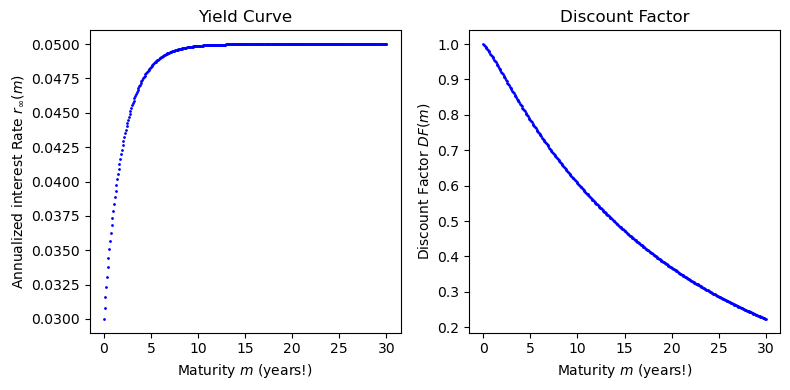

In [15]:
# This function defines the yield curve:
def fyc(m, parms):
    assert (type(parms) == np.ndarray and parms.shape == (3,)
           ), "Parameters parms should be a numpy array with three elements."
    # Parameters parms packed into numpy array for convenience in later use.
    # Unpack the parameters here so that they have intuitive names:
    rlong = parms[0]  # e.g., 0.0500
    rshort = parms[1] # e.g. 0.0300
    alpha = parms[2] #e.g. 0.50  # 1 / alpha = half-life of deviation from "long rate"
    
    # Now define the term structure function. 
    # NB: The np.exp function here not related to continuous compounding.
    r = rlong - (rlong - rshort) * np.exp(-alpha * m)  
    return r

# Construct a vector of parameters by defining the parameters a priori.
# (In a realistic application, these parameters would be estimated from data on securities prices)

rlong0 = 0.05
rshort0 = 0.03
alpha0 = 0.50
parms = np.array([rlong0, rshort0, alpha0])

# Plot the yield curve

mmax = 30.00 # years to plot on horizontal axis
nobs = 360 + 1 # The extra 1 makes the time between each observation equal to exactly one month.
m = np.linspace(start=0.00, stop=mmax, num=nobs, endpoint=True) # vector of maturities to plot
rm = fyc(m, parms) # vector of interest rates from yield curve

dfm = np.exp(-rm * m)  # continuously compounded discount factor for different maturities m

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(m, rm, 'bo', markersize=1.00)
ax[0].set_title("Yield Curve")
ax[0].set_xlabel("Maturity $m$ (years!)" )
ax[0].set_ylabel("Annualized interest Rate $r_\infty(m)$")

ax[1].set_title("Discount Factor")
ax[1].set_xlabel("Maturity $m$ (years!)")
ax[1].set_ylabel("Discount Factor $DF(m)$")
ax[1].plot(m, dfm, 'bo', markersize=1.00)

plt.tight_layout() # Prevents plots from being squashed together too much.

plt.show()


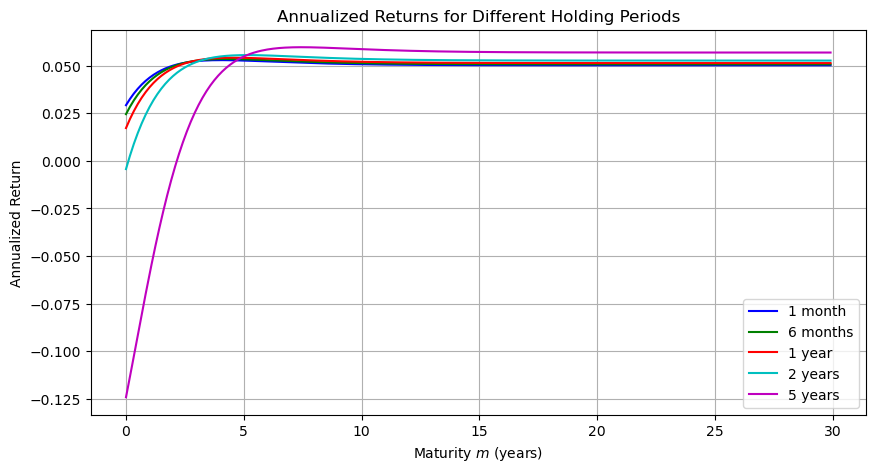

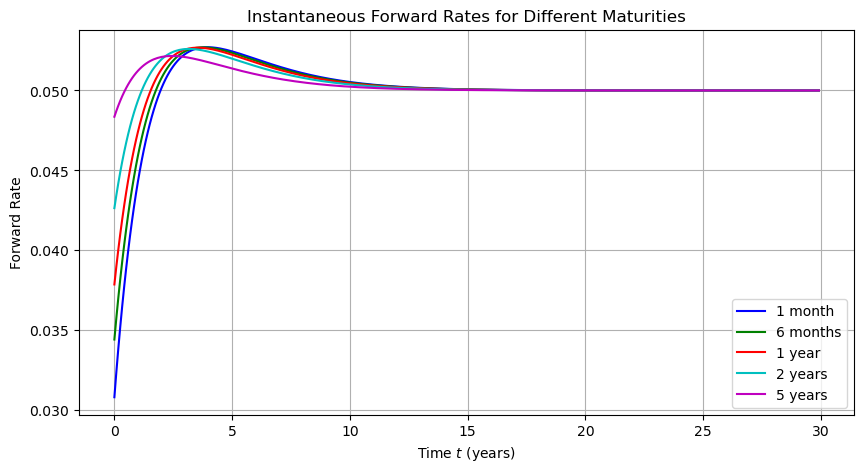

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def annualized_return(m, dt, parms):
    df_m = np.exp(-fyc(m, parms) * m)
    df_m_dt = np.exp(-fyc(m - dt, parms) * (m - dt))
    return (df_m_dt - df_m) / df_m / dt

dts = [1/12, 6/12, 1, 2, 5] # Holding periods: one month, six months, one year, two years, five years
colors = ['b', 'g', 'r', 'c', 'm']
labels = ["1 month", "6 months", "1 year", "2 years", "5 years"]

# Plot for riding the yield curve
plt.figure(figsize=(10,5))
for dt, color, label in zip(dts, colors, labels):
    returns = [annualized_return(mi, dt, parms) for mi in m]
    plt.plot(m[:-1], returns[:-1], color=color, label=label)  # Ignore the last value due to boundary conditions

plt.title("Annualized Returns for Different Holding Periods")
plt.xlabel("Maturity $m$ (years)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.show()

# Calculation of instantaneous forward rates
def forward_rate(t, dt, parms):
    rt = fyc(t, parms)
    rt_dt = fyc(t + dt, parms)
    return (rt_dt * (t + dt) - rt * t) / dt

# Plot for forward rates
plt.figure(figsize=(10,5))
for dt, color, label in zip(dts, colors, labels):
    rates = [forward_rate(ti, dt, parms) for ti in m[:-1]]
    plt.plot(m[:-1], rates, color=color, label=label)

plt.title("Instantaneous Forward Rates for Different Maturities")
plt.xlabel("Time $t$ (years)")
plt.ylabel("Forward Rate")
plt.legend()
plt.grid(True)
plt.show()


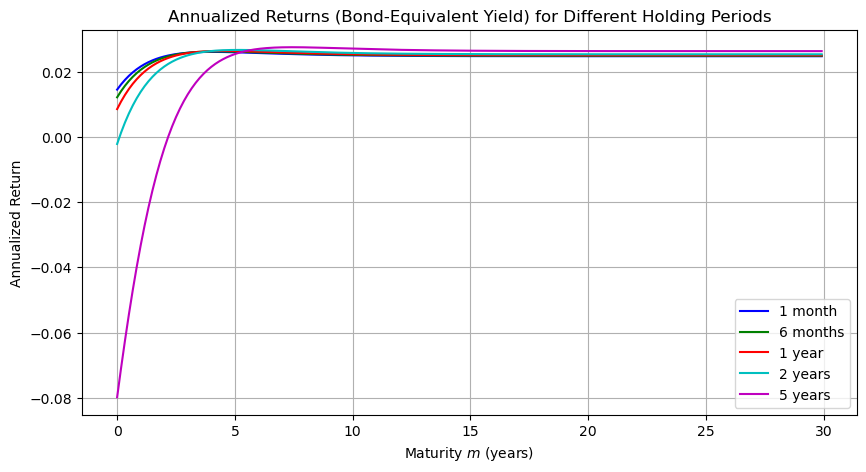

In [18]:
def discount_factor(m, parms):
    r_m = fyc(m, parms)
    bond_eq_yield = 2 * (np.sqrt(1 + r_m / 2) - 1)
    return (1 + bond_eq_yield / 2) ** (-2 * m)

def annualized_return_beq(m, dt, parms):
    df_m = discount_factor(m, parms)
    df_m_dt = discount_factor(m - dt, parms)
    return (df_m_dt - df_m) / df_m / dt

# Plot for riding the yield curve with bond-equivalent yield
plt.figure(figsize=(10,5))
for dt, color, label in zip(dts, colors, labels):
    returns = [annualized_return_beq(mi, dt, parms) for mi in m]
    plt.plot(m[:-1], returns[:-1], color=color, label=label)  # Ignore the last value due to boundary conditions

plt.title("Annualized Returns (Bond-Equivalent Yield) for Different Holding Periods")
plt.xlabel("Maturity $m$ (years)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.show()


### Exercise 3

Consider a bond with coupon rates $c \in \{0.00, 2.00, 4.00, \ldots, 20.00 \}$ per hundred dollars of face value and maturity $m \in \{2, 5, 10, 30 \}$ years, with semi-annual coupon payments.  For each maturity, generate two side-by-side plots. This first plot should show the price as a function of yields-to-maturity in the interval $[-2.00, 30.00]$ percent per year.  The second plot should show the yield duration as a function of yield to maturity. The third plot should show the yield to maturity as a function of prices in the range [p_0, p_1], where $p_0$ is the price corresponding to a yield to maturity of -2.00 percent per year and $p_1$ is the price corresponding to a yield to maturity of $30$ percent per year. 

Hint: Your algorithm should use an equation solving algorithm to to calculate the inverse function of inferring yield from price.



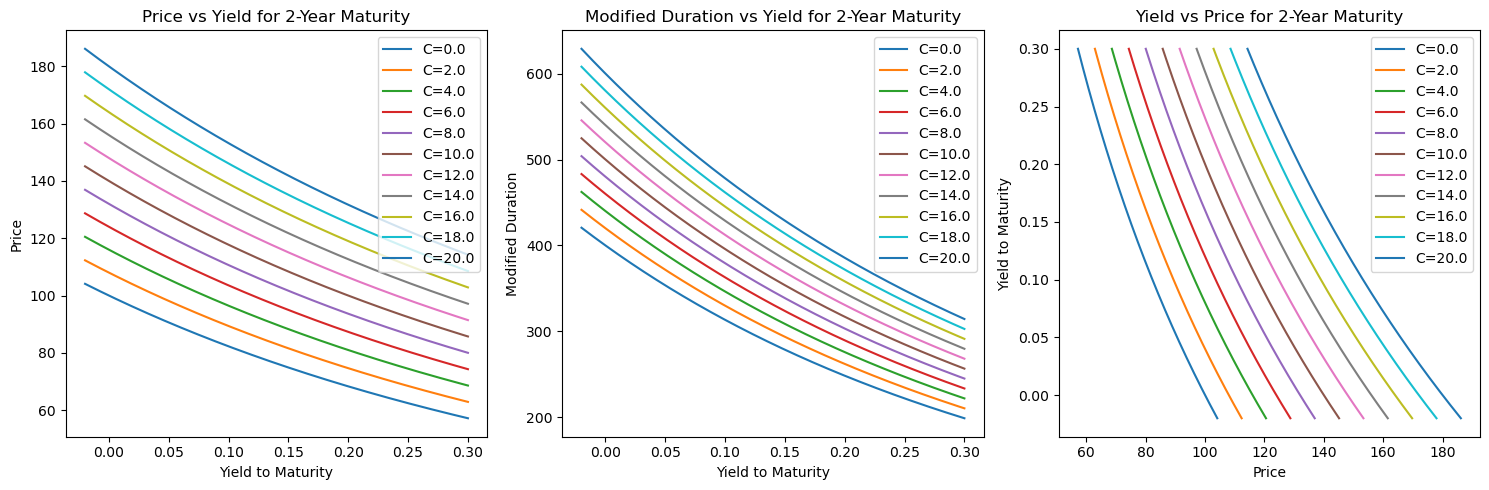

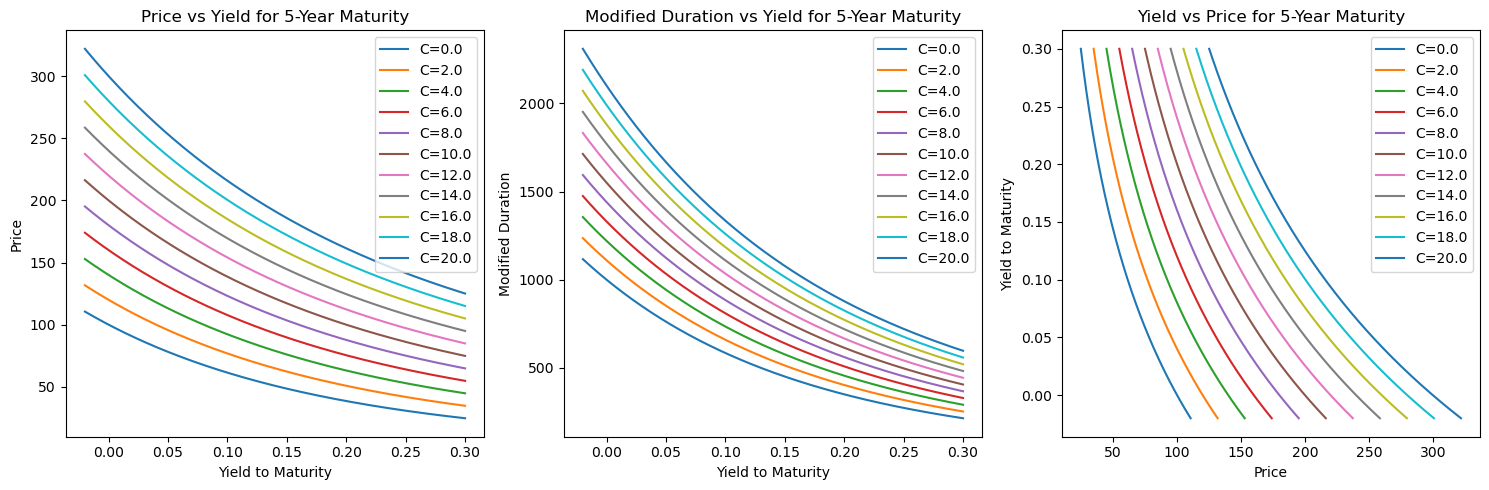

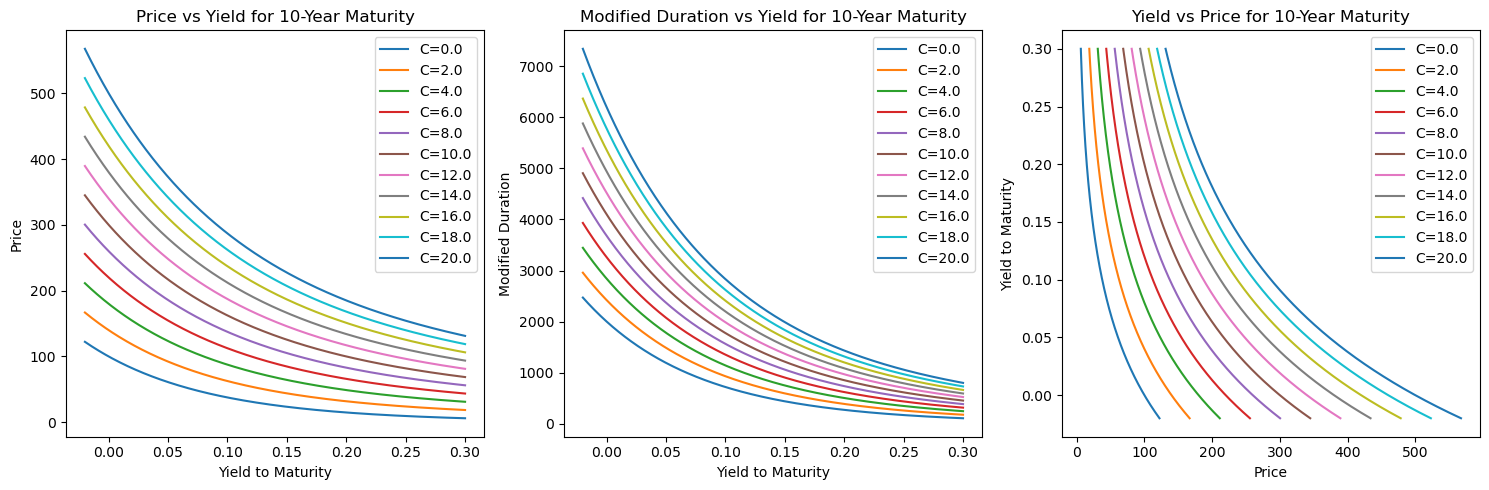

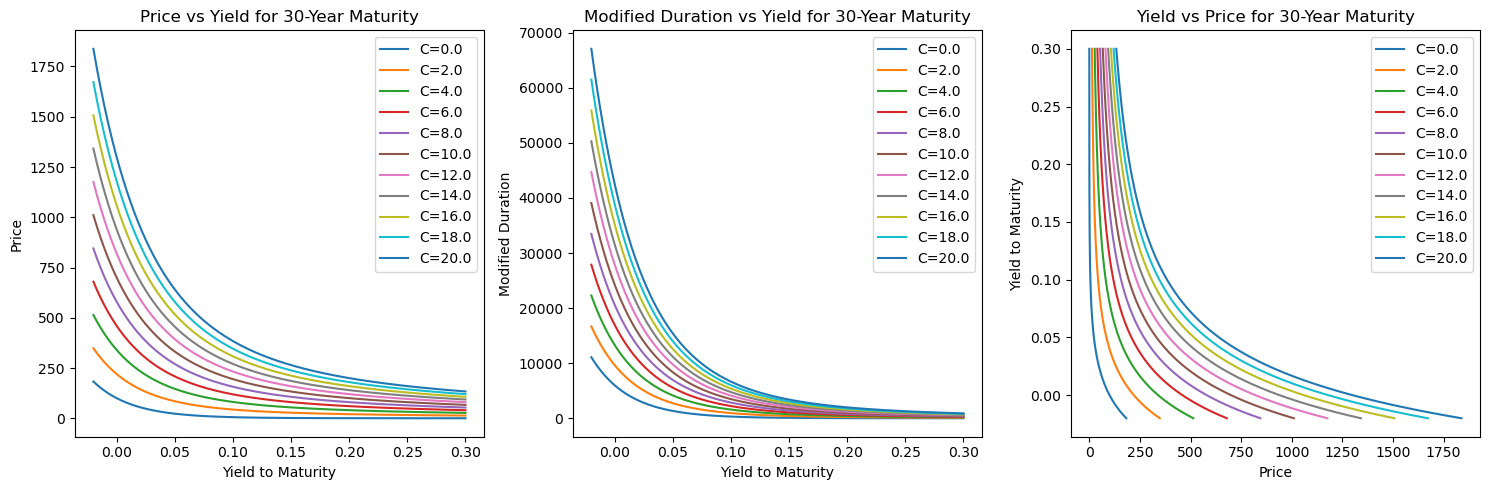

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

def bond_price(y, C, m, F=100):
    y /= 2  # Convert annual yield to semi-annual
    periods = 2 * m
    return C * (1 - (1 + y)**-periods) / y + F / (1 + y)**periods

def modified_duration(y, C, m, F=100):
    y /= 2  # Convert annual yield to semi-annual
    periods = 2 * m
    D = sum(t * C / (1 + y)**t for t in range(1, periods + 1)) + periods * F / (1 + y)**periods
    return D / (1 + y)

def yield_for_price(target_price, C, m, F=100):
    # Define the function whose root we want to find
    func = lambda y: bond_price(y, C, m, F) - target_price
    # Use Newton-Raphson method to find the yield for the given price
    return newton(func, 0.05)  # Initial guess is 5%

# Parameters
coupon_rates = np.arange(0, 20.5, 2)  # 0.00, 2.00, ... , 20.00
maturities = [2, 5, 10, 30]
yields = np.linspace(-0.02, 0.30, 500)

for m in maturities:
    plt.figure(figsize=(15, 5))

    # Plotting Price vs Yield
    plt.subplot(1, 3, 1)
    for c in coupon_rates:
        prices = [bond_price(y, c, m) for y in yields]
        plt.plot(yields, prices, label=f'C={c}')
    plt.title(f'Price vs Yield for {m}-Year Maturity')
    plt.xlabel('Yield to Maturity')
    plt.ylabel('Price')
    plt.legend()

    # Plotting Duration vs Yield
    plt.subplot(1, 3, 2)
    for c in coupon_rates:
        durations = [modified_duration(y, c, m) for y in yields]
        plt.plot(yields, durations, label=f'C={c}')
    plt.title(f'Modified Duration vs Yield for {m}-Year Maturity')
    plt.xlabel('Yield to Maturity')
    plt.ylabel('Modified Duration')
    plt.legend()

    # Plotting Yield vs Price
    plt.subplot(1, 3, 3)
    for c in coupon_rates:
        price_range = [bond_price(y, c, m) for y in [-0.02, 0.30]]
        inferred_yields = [yield_for_price(p, c, m) for p in np.linspace(*price_range, 500)]
        plt.plot(np.linspace(*price_range, 500), inferred_yields, label=f'C={c}')
    plt.title(f'Yield vs Price for {m}-Year Maturity')
    plt.xlabel('Price')
    plt.ylabel('Yield to Maturity')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Exercise 4: HARD: EXTRA CREDIT 

Write your own algorithm to calculate yield from price. Try to make it better than `scipy.optimize.minimize_scalar()` or `scipy.optimize.brentq` for the specific problem at hand.

This problem is a project for students who are mathematically and algorithmically inclined and probably are already quite familiar with Python.  You may work in groups on this problem. If so, please indicate on your homework whom you worked with.

Hints:

1. The problem has the nice property that price is a **monotonic** function of yield.  This means that there is only one solution to the problem, and it is easy to tell whether an incorrect guess is too large or too small.

2. There are three basic types of algorithms you might consider: bisection, secant method, and Newton's method.  The are mentioned in the notes and are easy to google.  All of them are straightforward to implement in principle but difficult to implement in practice due to various implementation details.

3. If the number of iterations does not vary too much from one calculation to the next, it might be far more computationally efficient to calculate the yield on many bonds simultaneously, by replacing a one-bond-at-a-time Python loop with numpy calculations on arrays with information about many bonds. The bisection method might work well using this approach.

4. Consider using the Numba package to speed up you algorithm to try to make it faster than `scipy.optimize.root_scalar`.




In [5]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
tfinish = timeit.default_timer()
print(f"Finished: {timestamp = }\nExecution time = {tfinish - tstart} seconds")


Finished: timestamp = '2023-09-19 13:03:20'
Execution time = 8.196546900000001 seconds
